# Get producer info

In this notebook we'll explore the producers of videos in the different infospheres. We will look at activity, size, topics development, and monetizing strategies and potential.


In [2]:
import pandas as pd #basically the engine for the whole analysis. 
import matplotlib.pyplot as plt #for plotting our data.
import glob #a nice library for iterating through multiple files.
import networkx as nx #we need this to construct and export network graphs.
import seaborn as sns; sns.set() #for plotting
import csv #for reading and writing csv's when we are not using the pandas library.
import re
import sys

csv.field_size_limit(sys.maxsize)

%matplotlib inline

In [3]:
# Set path to NL data - better to set these constants in a separate config file and import them here.

path_nl = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/NL/'

# Set path to control group data.

path_right = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/right/'

# Set path to international right data

path_left = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/left/'

# International right infosphere

We need:
1. Statistics on channels, videos and recommendations on the international right infosphere channels.
2. Topics of videos (by tags or through topic modelling).
3. Insight into the direction of the recommendations.


Let's start by looking at the channels.

## Channels

In [4]:
# Import the channel data into a dataframe.

channels = pd.read_csv(path_right + 'channels_right.csv')

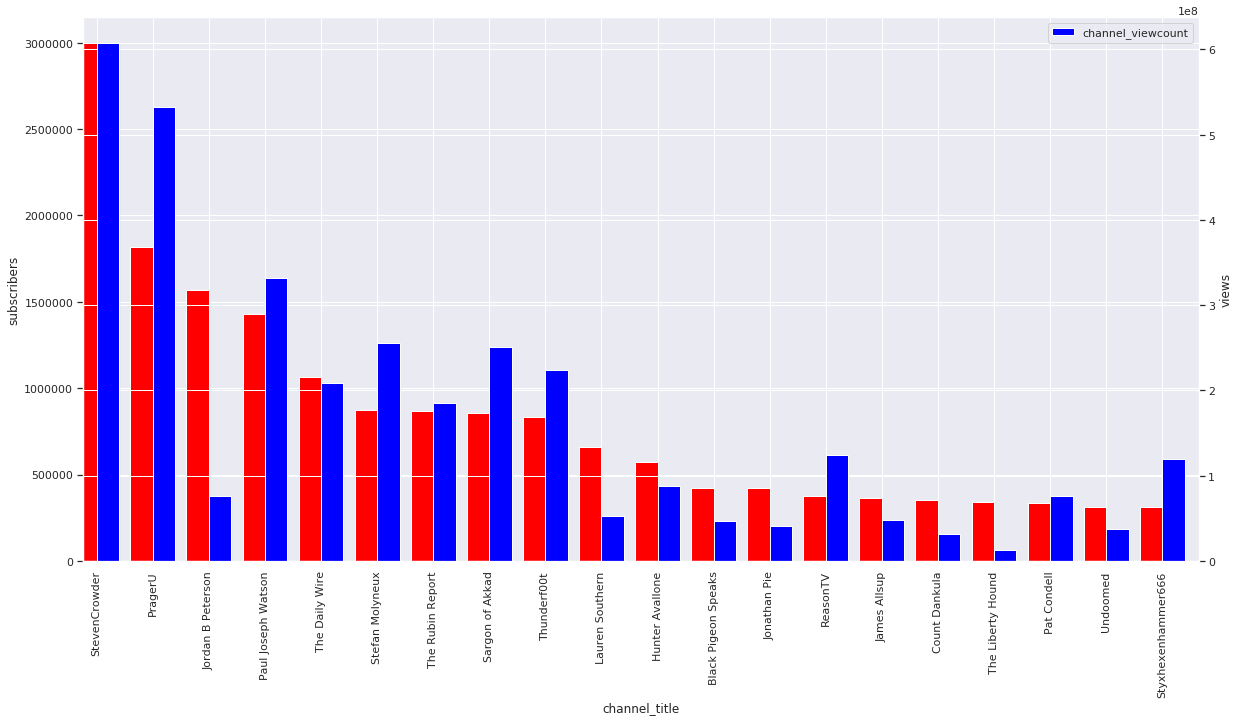

In [5]:

# Take a subset of the channel data.

stats = channels[['channel_title', 
                  'channel_description', 
                  'channel_subscribercount',
                  'channel_viewcount', 
                  'channel_videocount']]

stats = stats.sort_values(by='channel_subscribercount', ascending=False)[0:20]
stats.set_index("channel_title",drop=True,inplace=True)

# Create matplotlib figure.

fig = plt.figure(figsize=(20,10)) 

# Create matplotlib axes.

ax = fig.add_subplot(111) 

# Create another axes that shares the same x-axis as ax.

ax2 = ax.twinx() 

# Set a width for a bar chart.

width = 0.4

# Configure the bar chart.

stats.channel_subscribercount.plot(kind='bar', color='red', ax=ax, width=width, position=1)
stats.channel_viewcount.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, legend=True, grid=True)
ax.set_ylabel('subscribers')
ax2.set_ylabel('views')

plt.show()

# Show top20 channels viewcount (blue) and subscriptions (red)

Be careful, because there are two y-axis. The left is subscribers, the right is viewcount. 

That said though, there are some takeaways and caveats:
1. I'm describing a spectrum here. You may argue that PragerU for instance, or the Rubin Report don't belong to the far right. If you want to filter some channels out, you can use the code in the notebook of the Dutch right infosphere to do that.
2. That said, the size of some channels is pretty amazing. Take Paul Joseph Watson, a conspiracy theorist, working with Alex Jones. He's got close to a million and a half subscribers. Or Stefan Molyneux. 
3. There are a couple of channels that have many subscribers but not that many views (be mindful of the two axes). Jordan Peterson for instance. Lauren Southern, the Liberty Hound. What does that mean?

Get more statistics, now on videos.

In [5]:
# Load videos

videos = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')

In [44]:
# Add column with upload year

videos['video_upload_year'] = pd.DatetimeIndex(videos['video_published']).year

In [ ]:
# Filter out the channels we dropped before

videos = videos[~videos['video_channel_title'].isin(filter_out)]

In [45]:
videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262948 entries, 0 to 262947
Data columns (total 17 columns):
video_id                  262948 non-null object
video_published           262948 non-null object
channel_id                262948 non-null object
video_title               262948 non-null object
video_description         234509 non-null object
video_channel_title       262938 non-null object
video_tags                262938 non-null object
video_category_id         262938 non-null float64
video_default_language    262938 non-null object
video_duration            262938 non-null object
video_view_count          262938 non-null float64
video_comment_count       262938 non-null float64
video_likes_count         262938 non-null float64
video_dislikes_count      262938 non-null float64
video_topic_ids           262938 non-null object
video_topic_categories    262938 non-null object
video_upload_year         262948 non-null int64
dtypes: float64(5), int64(1), object(11)
memory usag

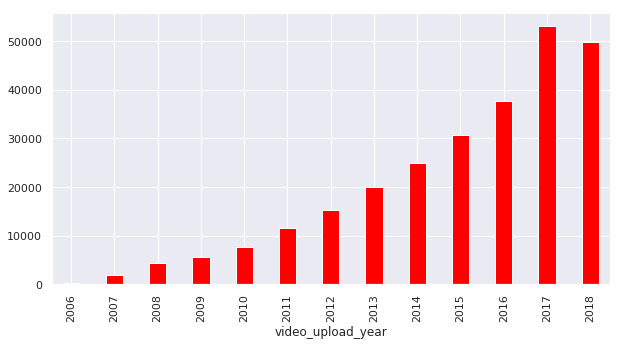

In [46]:
# Plot views and uploads per year.

uploads_per_year = videos.groupby(['video_upload_year']).size()
views_per_year = videos.groupby(['video_upload_year'])['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

uploads_per_year.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()



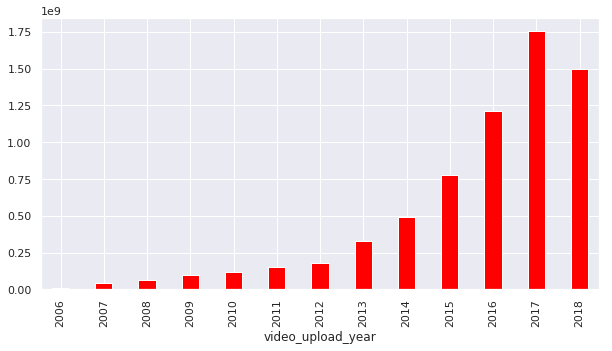

In [47]:
# Then the views per year.

fig = plt.figure(figsize=(10,5))
width = 0.4

views_per_year.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

In 2018 more videos were uploaded, but they've gotten significantly lesser views. It could be that older video's are still getting views. 

## Show channel development over time

Socialblade.com provides a range of statistics on YouTube channels, like daily views and subscription info. I've run the list of channels through [socialblade.com](https://www.socialblade.com). I want to try to get a sense of the the growth of the infospheres in recent years, maybe in a bubble flow chart. It would make a great comparisson with other information networks on YouTube. We can use four axes for that:
- x = monthly_views
- y = monthly_subscriptions
- z = monthly_comments (z is size of the bubble)
- plus time

The only constraint is that the oldest data is from early 2015, so it's not that old.

I'll prepare the data for use in [gapminder](https://www.gapminder.org/tools/), an easy way to explore this kind of data.

In [48]:
# Import the data from socialblade

channel_history = pd.read_csv(path_right + 'other_platforms/socialblade_right_monthly.csv')


In [49]:
# Extract all the dates and values of two columns: daily views and total subs

pattern = re.compile('(\d{4}-\d{2}-\d+,\d+)')

# And create two new columns with lists of dates and values found

channel_history['daily_views'] = channel_history['Date_Daily_Views'].str.findall(pattern)
channel_history['daily_subs'] = channel_history['Date_Total_Subs'].str.findall(pattern)

# Stack them, so all the dates and values are linked to the channels and
# we are getting rid of the messy lists.

daily_views = channel_history.set_index('User') \
            .daily_views.apply(pd.Series) \
            .stack() \
            .reset_index(level=-1, drop=True) \
            .reset_index()

# Extract the values columns for views and subscriptions (subs)

daily_views['date'], daily_views['views'] = daily_views[0].str.split(',', 1).str
daily_views = daily_views[['User', 'date', 'views']]
daily_views = daily_views.rename(columns = {'User': 'channel_id'})

daily_subs = channel_history.set_index('User') \
            .daily_subs.apply(pd.Series) \
            .stack() \
            .reset_index(level=-1, drop=True) \
            .reset_index()

daily_subs['date'], daily_subs['subs'] = daily_subs[0].str.split(',', 1).str
daily_subs = daily_subs[['User', 'date', 'subs']]
daily_subs = daily_subs.rename(columns = {'User': 'channel_id'})

# And bring it all together in a dataframe called daily_stats

daily_stats = pd.merge(daily_subs, daily_views,  how='left', left_on=['channel_id', 'date'], right_on = ['channel_id', 'date'])


In [51]:
# Now we need to add some data, first the channel data (like channel_title, etc.)

# Import the channel data if you haven't imported the channels yet.

# channels = pd.read_csv(path_nl + 'channels_nl_right.csv')

# And merge them with daily_stats

channel_daily_stats = pd.merge(daily_stats, channels, on='channel_id', how='left')

# Drop empty values

channel_daily_stats = channel_daily_stats.dropna()

In [52]:
# We need to get the average (mean) views and subs per year, month and year_month

# The date is not recognized as a date

channel_daily_stats['date'] = pd.to_datetime(channel_daily_stats['date'])

# Get year_month (yyyy-mm format)

channel_daily_stats['yearmonth'] = channel_daily_stats['date'].dt.to_period('M')

# The values of subs and views are floats in stead of integers, which will get us into trouble later on

channel_daily_stats['subs'] = channel_daily_stats['subs'].astype('int')
channel_daily_stats['views'] = channel_daily_stats['views'].astype('int')


In [ ]:
# Filter some channels out if necessary

right_channel_daily_stats = channel_daily_stats[~channel_daily_stats['channel_title'].isin(filter_out)]

In [54]:
# Then it's time to get the comments and average out the comments per month

# Import the comments using an iterator (the comments file is quite large)

cols_to_keep = ['video_id', 'comment_time']

iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        usecols=cols_to_keep,
                        iterator=True, 
                        chunksize=100000,
                        sep='¶',
                        quotechar='þ',
                        engine='python'
                        )
comments_we_need = pd.concat([chunk for chunk in iter_csv])


In [ ]:
# Add channel data to comments_we_need


comments_channels_to_clean = pd.merge(comments_we_need, videos[['video_id', 'video_channel_title']], on='video_id').dropna()

# Parse some dates.

comments_channels_to_clean['comment_time'] = pd.to_datetime(comments_channels_to_clean['comment_time'], errors='coerce')
comments_channels_to_clean['yearmonth'] = comments_channels_to_clean['comment_time'].dt.to_period('M')

# And clean it up a bit.

comments_channels_to_clean = comments_channels_to_clean.rename(columns = {'video_channel_title': 'channel_title'})



In [ ]:
# Prepare the data for merging - the code is still quite messy

comments_channels_to_clean = comments_channels_to_clean[['channel_title', 'yearmonth']]

merged_comments = pd.merge(channel_daily_stats, 
                            comments_channels_to_clean, 
                            on=['channel_title', 'yearmonth'], 
                            how='left')



In [ ]:
merged_comments = merged_comments.groupby([merged_comments.channel_title, 
                                           merged_comments.yearmonth ]) \
                                           .agg({'channel_id': 'count', 'subs':'mean', 'views':'mean'})

In [ ]:
merged_comments = merged_comments.rename(columns={'channel_id': 'comments'})
merged_comments.to_csv(path_right + '/temp_data/right_monthly_development_for_gapminder.csv')

You can find the Gapminder file [here](https://drive.google.com/open?id=1t9_lS314Li2M_Kwe5eI0Oozh64RtAxzD). You can see clearly the rise of FvD. But one interesting channel is Leukste YouTube Fragmenten. It shows a lot of steep peeks, which says something about the virality of its content.

## Get some statistics on the relative size and performance of the channels

Socialblade tracks many, many channels and also ranks channels according to some benchmarks. Let's have a look at these rankings. This time we'd better include channels like GeenStijl to get a sense of the importance, or lack thererof of these channels. The data is downloaded in November 2018 and represents a snapshot of that moment. For more information on the metrics, see the [FAQ of Socialblade.](https://socialblade.com/youtube/help)

For your idea:

Volkskrant ranks:
- Grade: C+
- Subscriber rank: 1,001,161st
- Video view rank: 502,428th
- Socialblade rank: 523,376th
- Estimated Monthly Earnings: €29 - €459
- Estimated Yearly Earnings: €344 - €5.5K

De Correspondent ranks:
- Grade: C
- Subscriber rank: 1,832,426th
- Video view rank: 5,212,726th
- Socialblade rank: 4,469,657th
- Estimated Monthly Earnings: €0.47 - €8
- Estimated Yearly Earnings: €6 - €90

In [6]:
channel_ranking = pd.read_csv(path_right + 'other_platforms/socialblade_right_summary.csv')

Clean the data up a bit, so we can actually do some calculations and visualisations

In [7]:
channel_ranking['Source Url'] = channel_ranking['Source Url'].str.replace('https://socialblade.com/youtube/channel/', '')
channel_ranking['Subscriber_Rank'] = channel_ranking['Subscriber_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)
channel_ranking['Video_View_Rank'] = channel_ranking['Video_View_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)
channel_ranking['Sb_Rank'] = channel_ranking['Sb_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)

In [8]:
channel_ranking['earnings_low'], channel_ranking['earnings_high'] = channel_ranking['Estimated_Yearly_Earning'].str.split('-', 1).str
channel_ranking['earnings_low'] = channel_ranking['earnings_low'].replace('\D', '', regex=True).apply(pd.to_numeric)
channel_ranking['earnings_high'] = channel_ranking['earnings_high'].replace('\D', '', regex=True).apply(pd.to_numeric)

In [9]:
channel_ranking = channel_ranking.rename(columns={'Source Url': 'channel_id',
                                                'Subscriber_Rank': 'subscriber_rank',
                                                'Video_View_Rank': 'video_view_rank',
                                                'Sb_Rank': 'sb_rank',
                                                  'Grade': 'grade'
                                               })

In [10]:
# Merge with channels

ranking = pd.merge(channel_ranking, channels, on='channel_id', how='left')

In [11]:
ranking_final = ranking[['channel_title', 
                   'subscriber_rank', 
                   'video_view_rank', 
                   'sb_rank', 
                   'grade', 
                   'earnings_low',
                   'earnings_high'
                  
                  ]]

In [12]:
ranking_final.sort_values('sb_rank')

,channel_title,subscriber_rank,video_view_rank,sb_rank,grade,earnings_low,earnings_high
82,StevenCrowder,2088.0,3433.0,2489.0,B+,846.0,14.0
118,PragerU,4402.0,3998.0,3298.0,B+,869.0,14.0
40,The Daily Wire,8679.0,11607.0,5293.0,B+,511.0,8174.0
616,THE MERKINS,66305.0,113601.0,8263.0,B+,182.0,2918.0
130,Timcast,85993.0,100993.0,16358.0,B,217.0,3478.0
29,Styxhexenhammer666,34383.0,21544.0,16789.0,B,242.0,3879.0
150,The Patriotic Report,24218778.0,107455.0,17451.0,B,182.0,2906.0
99,Paul Joseph Watson,6182.0,7228.0,20978.0,B,186.0,2972.0
236,James Allsup,29472.0,55864.0,24510.0,B,9.0,1441.0
102,The Thinkery,34743.0,34478.0,29734.0,B,138.0,2214.0


So, if we look at the sb-ranking, Volkskrant would be between Paul Nielsen and TPO. De Correspondent between De Dagelijkse Standaard and Batavieren Podcast. De Correspondent actually scores worse than Erkenbrand for what it's worth.

## So what are these videos about?

Let's get a sense of the topic discussed in the NL right infosphere by looking at the tags. 

In [ ]:
vidtags = videos[['video_id', 'video_title', 'video_tags']]

video_tags = vidtags['video_tags'].str.replace(r"\[|\]|\'|-", '') \
                    .str.lower() \
                    .str.split(', ', expand=True) \
                    .merge(vidtags, right_index = True, left_index = True) \
                    .drop(["video_tags"], axis = 1) \
                    .melt(id_vars = ['video_id', 'video_title'], value_name = "tag") \
                    .drop(['variable'], axis=1) \
                    .dropna()

video_tags = video_tags[~video_tags['tag'].str.contains('not set')]
video_tags.sort_values('tag', inplace=True)
video_tags.tag.nunique()

Maybe start with broad categories where politicians are associated with their parties, so Baudet becomes fvd. Rutte vvd, etc.

In [ ]:
video_tags.loc[video_tags['tag'].str.contains('pvv|partij voor de vrijheid|dion grau|wilders|party for free|bosma$|^geert$|agema|lilian h|machiel d|beertema|fritsma|marcel de graa|madlener|de roon'), 'tag'] = 'pvv'
video_tags.loc[video_tags['tag'].str.contains('partijkart|forum|fvd|baudet|thierry|hiddema|forum voor democratie|forum democr|jfvd|jongeren forum voo|^yernaz'), 'tag'] = 'fvd'
video_tags.loc[video_tags['tag'].str.contains('vvd|^rutte|^premier|dijkhoff|v.v.d'), 'tag'] = 'vvd'
video_tags.loc[video_tags['tag'].str.contains('arib$|asscher|partij van de arb|p.v.d.a.|pvda'), 'tag'] = 'pvda'
video_tags.loc[video_tags['tag'].str.contains('kuzu|azarkan|^denk$'), 'tag'] = 'denk'
video_tags.loc[video_tags['tag'].str.contains('^klaver$|jesse klaver|^gl$|groenlinks|halsema'), 'tag'] = 'groenlinks'
video_tags.loc[video_tags['tag'].str.contains('^buma$|cda|sybrand v|sybrand b|christendemo'), 'tag'] = 'cda'
video_tags.loc[video_tags['tag'].str.contains('musli|sharia|^isis$|terror|qura|muham|allah|islam|imam|prediker|mosli|hoofddoe|kopvod|moskee|mohamme|jihad|koran'), 'tag'] = 'islam'
video_tags.loc[video_tags['tag'].str.contains('refugees|rapefugees|vluchteli|asiel|azc|migrati|immigra|gelukszoe'), 'tag'] = 'migratie'
video_tags.loc[video_tags['tag'].str.contains('voetba|knvb|wilfr|derksen|ajax|feyeno|fc |psv|eredivi|vitesse|gijp|genee|^az$|hans kraay'), 'tag'] = 'voetbal'
video_tags.loc[video_tags['tag'].str.contains('^ep$|geenpeil|^eu$|europe|^europa$|straatsburg|brussel|^euro$|eussr'), 'tag'] = 'europa'
video_tags.loc[video_tags['tag'].str.contains('^npo$|^kro$|omroep|business class|talkshow|rtl|pauw|witteman|jinek|ncrv|bnr|vara'), 'tag'] = 'tv'
video_tags.loc[video_tags['tag'].str.contains('parlement|^motie|^kamer$|eerste kamer|minister|plenaire|kabinet|^tweede$|politiek|politic|regering|2e ka|tweede kame|beschouwin'), 'tag'] = 'politiek'
video_tags.loc[video_tags['tag'].str.contains('d66|democraten 66|ollongre|pechtold'), 'tag'] = 'd66'
video_tags.loc[video_tags['tag'].str.contains('^formatie|tk2017|peiling|kiezen|verkiezing|zetel'), 'tag'] = 'verkiezingen'
video_tags.loc[video_tags['tag'].str.contains('multicul|multikul|integratie'), 'tag'] = 'integratie'
video_tags.loc[video_tags['tag'].str.contains('turk|erdoga'), 'tag'] = 'turkije'
video_tags.loc[video_tags['tag'].str.contains('^politie$|criminal}rechtzaa|rechtszaa|criminel|justitie|misda|misdr'), 'tag'] = 'veiligheid'
video_tags.loc[video_tags['tag'].str.contains('holland|netherland|nederland|dutch'), 'tag'] = 'nederland'
video_tags.loc[video_tags['tag'].str.contains('marok|maroc'), 'tag'] = 'marokkanen'
video_tags.loc[video_tags['tag'].str.contains('^pim$|pim f|fortuyn|lpf'), 'tag'] = 'fortuyn'
video_tags.loc[video_tags['tag'].str.contains('^zwarte$|zwarte piet|sinterklaas|sint en|sylvana|simons|discrimi|racis'), 'tag'] = 'discriminatie'
video_tags.loc[video_tags['tag'].str.contains('thieme|partij voor de dieren|pvdd'), 'tag'] = 'pvdd'
video_tags.loc[video_tags['tag'].str.contains('roemer|socialistische partij|^sp$'), 'tag'] = 'sp'
video_tags.loc[video_tags['tag'].str.contains('jan roos|janroos|laviejan|^vnl$|voornl|voorneder'), 'tag'] = 'jan roos'
video_tags.loc[video_tags['tag'].str.contains('begroting|bezuinig|financ|dividen'), 'tag'] = 'financien'
video_tags.loc[video_tags['tag'].str.contains('ouderen|invalid|^zorg$|gehandic'), 'tag'] = 'zorg'
video_tags.loc[video_tags['tag'].str.contains('links|progressi|sociali|communis'), 'tag'] = 'links'





In [ ]:
video_tags.tag.value_counts()

This all feels very cumbersome. 

Maybe we can just search by topic, which might be more efficient.

In [40]:
query_topic = 'biological_racism'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['race realism', 'race and iq', 'jared taylor',
         'biological racism', 'american rennai',
         '^amren$', 'greg johnson', 'haplot',
         'eugenics', 'bell curve', 'charles murray',
        ]

In [41]:
pattern = '|'.join([s for s in query])
mask = videos['video_tags'].str.contains(pattern, regex=True, case=False, na=False)
result = videos[mask]

len(result)

1317

In [42]:
result

,video_id,video_published,channel_id,video_title,video_description,video_channel_title,video_tags,video_category_id,video_default_language,video_duration,video_view_count,video_comment_count,video_likes_count,video_dislikes_count,video_topic_ids,video_topic_categories
2478,j_jz5c3GVVg,2014-09-22T18:01:15.000Z,UCittVh8imKanO_5KohzDbpg,Mysterious Georgia Guidestones Get Strange '20...,"The mysterious Georgia Guidestones, which some...",Paul Joseph Watson,"['Georgia Guidestones (Structure)', 'georgia g...",25.0,not set,PT4M,384777.0,989.0,2177.0,140.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']
2663,nqMSPooXJIk,2012-10-11T16:34:32.000Z,UCittVh8imKanO_5KohzDbpg,"Bill Maher: ""We Need To Promote Death""",During a recent appearance on the StarTalk Rad...,Paul Joseph Watson,"['Bill Maher (Comedian)', 'abortion', 'death p...",25.0,not set,PT1M52S,67373.0,644.0,314.0,313.0,"['/m/02jjt', '/m/02jjt']",['https://en.wikipedia.org/wiki/Entertainment']
2701,mezKK8NJCy8,2011-07-19T19:51:14.000Z,UCittVh8imKanO_5KohzDbpg,Beckham Vs New World Order - Part 2,The fact that the leaders of a movement that i...,Paul Joseph Watson,"['Beckham', 'Eugenics', 'Climate', 'Globalwarm...",27.0,not set,PT2M1S,7225.0,15.0,188.0,6.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']
2702,AFyhH5UIdoU,2011-07-19T19:46:24.000Z,UCittVh8imKanO_5KohzDbpg,Beckham Vs New World Order - Part 1,The fact that the leaders of a movement that i...,Paul Joseph Watson,"['Beckham', 'Newworldorder', 'Globalwarming', ...",27.0,not set,PT8M44S,22052.0,62.0,335.0,10.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']
3045,hsKOmEZ-b-o,2016-02-14T03:24:19.000Z,UCLfhh63n0fWn0gXXKQ5NWvw,"[Hangout] The Alt-Left (with Rabbit, Greg John...","""The other red pill...""\n\nhttp://altleft.com/...",Millennial Woes,"['reactosphere', 'eugenics', 'dysgenics', 'fem...",25.0,not set,PT2H22M20S,10614.0,387.0,210.0,69.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']
9593,lxz8LNtMS4w,2018-03-12T19:45:33.000Z,UCaeO5vkdj5xOQHp4UmIN6dw,The Left Unleashes Its Crazy | The Ben Shapiro...,"The Left embraces socialism, eugenics, and rev...",The Daily Wire,"['Donald Trump', 'OJ Simpson', 'abortion', 'Do...",25.0,not set,PT55M6S,165014.0,832.0,2752.0,127.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Politics', 'ht..."
9671,I-grxYt1yzk,2018-02-20T01:04:49.000Z,UCaeO5vkdj5xOQHp4UmIN6dw,Is The Ivy League Destroying America? ft. Prof...,"Statue-toppling, shrieking girls, white suprem...",The Daily Wire,"['Professor Carol Swain', 'Ivy League', 'Chris...",25.0,not set,PT42M29S,104812.0,93.0,524.0,67.0,"['/m/098wr', '/m/05qt0', '/m/098wr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Society', 'htt..."
9785,WuXWDXyr3MY,2018-01-26T00:39:26.000Z,UCaeO5vkdj5xOQHp4UmIN6dw,Cecile Richards' Legacy Is Millions Of Dead Ba...,Michael and Liz Wheeler reflect on the legacy ...,The Daily Wire,"['planner parenthood', 'abortion', 'cecile ric...",25.0,not set,PT3M54S,16016.0,265.0,550.0,36.0,"['/m/02jjt', '/m/02jjt']",['https://en.wikipedia.org/wiki/Entertainment']
11502,nehJfvlQb6M,2016-03-03T15:54:51.000Z,UC0uVZd8N7FfIZnPu0y7o95A,How America's Welfare System Hurts the People ...,"At around $700 billion a year, federal spendin...",ReasonTV,"['snap benefits', 'food stamps', 'EITC', 'welf...",25.0,not set,PT18M22S,28720.0,311.0,660.0,51.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']
12135,zAA2eK1K3pw,2013-10-28T16:05:43.000Z,UC0uVZd8N7FfIZnPu0y7o95A,Margaret Sanger Was Anti-Abortion!?!? Peter Ba...,"Did you know that Margaret Sanger (1879-1966),...",ReasonTV,"['reason', 'reason.com', 'reason.org', 'reason...",25.0,not set,PT6M22S,8985.0,189.0,119.0,200.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society']


In [44]:
#Run the results through the comment file to get the commenters

vids = result.video_id.unique().tolist()


iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
result_comments = pd.concat([chunk[chunk['video_id'].isin(vids)] for chunk in iter_csv])
len(result_comments)

In [47]:
#Get a list of the commenters

commenters = result_comments.author_channel_id.unique().tolist()

In [ ]:
# And get all of their comments in the right infosphere

In [1]:
iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
commenters_history = pd.concat([chunk[chunk['author_channel_id'].isin(commenters)] for chunk in iter_csv])
len(commenters_history)

NameError: name 'pd' is not defined

## And then, the recommendations

We are not 100 percent sure where the recommendations you can get through the API are produced, because YouTube is mum about that. What we know is, that there are different kind of recommendations:
1. Recommended - these are probably based on co-watching behavior. So people who watched this video also watch...
2. Recommended for you - personalized recommendations, probably based on many, many metrics.
3. Topics on your YT-homescreen. They seem to pull you further into a niche you already like.

Here' we will focus on the first type, the semi-static recommendations that are based (probably) on co-watching behavior.

In [ ]:
vids_of_interest = result_comments.video_id.unique().tolist()

In [ ]:
iter_csv = pd.read_csv(path_right + 'recommendations_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
recommendations = pd.concat([chunk[chunk['videoId'].isin(vids_of_interest)] for chunk in iter_csv])
len(recommendations)

In [ ]:
# Merge recommendations with videos

recs_with_source_videos = pd.merge(recommendations, 
                                   videos[['video_id',                                           
                                        'video_channel_title', 
                                        'video_published', 
                                        'video_tags', 
                                        'video_duration',
                                        'video_view_count']],
                                   on='video_id', 
                                   how='left')

In [ ]:
# TODO get data for target videos, preferably channel and video data.
# Add channel names to target video so we can make channel to channel comparissons.

recs_chans = pd.read_csv(path_right + 'temp_data/recs_chans.csv')
recs = pd.merge(recs_with_source_videos, recs_chans[['channel_id', 'channel_title']], on='channel_id', how='left')

# And clean the column names up

recs = recs.rename(columns={'channel_id':'target_channel_id',
                    'channel_title':'target_channel_title',
                    'video_id':'source_video_id',
                    'published_at':'target_published_at',
                    'channel_id': 'target_channel_id',
                    'video_title':'target_video_title',
                    'video_description':'target_video_description',
                    'video_channel_title':'source_channel_title',
                    'video_published':'source_video_published',
                    'video_tags':'source_video_tags',
                    'video_duration':'source_video_duration',
                    'video_view_count':'source_video_view_count'})

In [ ]:
# Let's look at a sample of the data.

recs.sample(5)

TODO: It might be interesting to get target video data as well. We could then get more information on how the recommendation actually works. Do videos on certain topics point to the same topics? Or what is the influence of length or publication date on videos? 

It's not trivial to do this, and my suggestion would be that we would only do this if we have more time and not with the Dutch infosphere, because this space is rather small. I would rather do this at the international left and right infospheres. 

### Filter recommendations by channel

Pick a channel and see which other channels are recommended. You could intepret this as follows: the result are channels that host videos that are recommended if you watch a video of the channel you picked. It would seem (be careful) that YouTube thinks at this point in time (November 2018) that these channels (through their videos) are related. 

In [ ]:
# Pick a channel

chan = '' #fill in a channel here

# And filter

filtered_recs = recs[recs['source_channel_title'] == chan]

In [ ]:
top_channels = filtered_recs.target_channel_title.value_counts()[0:20]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

top_channels.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()

### See recommendations by topic

We could do the same tric we did before: use the video tags to get a group of videos about a certain topic. Then we can see what channels (and videos) are recommended

In [ ]:
# You can pick another video of this list of videps of selected channel.

query_topic = 'sylvana'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['sylvana', 'bij1', 'simons']

In [ ]:
pattern = '|'.join([s for s in query])
mask = recs['source_video_tags'].str.contains(pattern, regex=True, case=False, na=False)
result = recs[mask]

len(result)

In [ ]:
top_channels = result.target_channel_title.value_counts()[0:20]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

top_channels.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()

In [ ]:
top_videos = result.target_video_title.value_counts()[0:20]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

top_videos.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()